In [32]:
import glob
import os
import numpy as np
import pandas as pd
import xarray as xr
import time
import datetime as dt
import geopy
import geopy.distance
import cartopy.crs as crs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter)

In [33]:
#need to add if buoylist is None to the arguement list 
def dup_buoyid_test(buoyid, buoylist):
    #to use as a check later
    if buoyid in buoylist:
        print('\nWarning! There is a duplicate buoyid!\n' + str(buoyid, fname) 
              + '\nexiting because this really should be fixed!')
        exit()
    else:
        buoylist.append(buoyid)
    return buoylist
        

def wrap_to_180(x):
    """Wrap values in degrees into the interval [-180, 180]."""
    with np.errstate(invalid='ignore'):
        x_wrap = np.remainder(x, 360)
    x_wrap[x_wrap > 180] -= 360
    return x_wrap


def impossible_coordinate_test(df):
    df.loc[(df['LATITUDE'] > 90), 'LATITUDE'] = np.nan
    df.loc[(df['LATITUDE'] < -90), 'LATITUDE'] = np.nan
    df.loc[(df['LONGITUDE'] < -360), 'LONGITUDE'] = np.nan
    df.loc[(df['LONGITUDE'] > 360), 'LONGITUDE'] = np.nan
    df['LONGITUDE'] = wrap_to_180(df['LONGITUDE'])
    #drop rows where the lats or lons are set to NaN
    df.dropna(inplace=True)
    return df


def impossible_time_test(df, hdrdict):
   
    #This should be done per point, but right now it just checks that the min
    #and max points are realistic.

    #add a column (time) with seconds since start and drop duplicates
    df.reset_index(inplace=True)
    df.sort_values('TIME', inplace=True)
    df.reset_index(inplace=True)
    df.drop('index', axis=1, inplace=True)
    df['time'] = (df['TIME'] - df['TIME'][0]).apply(lambda x: x.total_seconds())
    df.drop_duplicates(subset=['time'], keep='first', inplace=True)

    #check if min/max data times match header start/end times
    first_time = pd.to_datetime(str(df['TIME'].values[0])).strftime('%Y-%m-%d %H:%M:%S')
    last_time = pd.to_datetime(str(df['TIME'].values[-1])).strftime('%Y-%m-%d %H:%M:%S')

    #seconds_in_day = 24 * 60 * 60
    
    def confirm_earlier_than_today(data_date):
        # data start date should be earlier than today, but greater than 1970
        todaysdate = dt.datetime.today().strftime('%Y-%m-%d %H:%M:%S')
        todaysdate_num = dt.datetime.strptime(todaysdate, '%Y-%m-%d %H:%M:%S')
        timenum = dt.datetime.strptime(data_date, '%Y-%m-%d %H:%M:%S')
        if todaysdate_num.date() < timenum.date():
            print(str(data_date) + 'is later than today\'s date. Exiting!')            
            exit()
        
    confirm_earlier_than_today(first_time)
    confirm_earlier_than_today(last_time)
    
    def confirm_later_than_1970(data_date):
        # data end date should be earlier than today
        sfr = '1970-01-01 00:00:00'
        sfr_num = dt.datetime.strptime(sfr, '%Y-%m-%d %H:%M:%S')
        timenum = dt.datetime.strptime(data_date, '%Y-%m-%d %H:%M:%S')
        if sfr_num.date() > timenum.date():
            print('The data date is earlier than 1970-01-01. This is unlikely, so exiting')
            exit()
    
    confirm_later_than_1970(first_time)
    confirm_later_than_1970(last_time)
    #df.drop('level_0', axis=1, inplace=True)
    #df.drop('time', axis=1, inplace=True)

    
def impossible_speed_test(df): 
 
    #manipulate the time and drop duplicates
    df.reset_index(inplace=True)
    df.sort_values('TIME', inplace=True)
    df.reset_index(inplace=True)
    #df.drop('level_0', axis=1, inplace=True)
    df.drop('index', axis=1, inplace=True)
    df['time'] = (df['TIME'] - df['TIME'][0]).apply(lambda x: x.total_seconds())
    df.drop_duplicates(subset=['time'], keep='first', inplace=True)
    
    #determine some dates
    launchdate = pd.to_datetime(str(df['TIME'].values[0])).strftime('%Y%m%d')
    firsttime = pd.to_datetime(str(df['TIME'].values[0])).strftime('%Y-%m-%d %H:%M:%S')
    lasttime = pd.to_datetime(str(df['TIME'].values[-1])).strftime('%Y-%m-%d %H:%M:%S')

    # Dropping bad speed points
    changed = True
    std = None
    mean = None

    drop_counter = 0
    while changed:
        df.reset_index(inplace=True)
        df.drop('index', axis=1, inplace=True)

        # Get geopy points for each lat,lon pair
        points = df[
            ['LATITUDE', 'LONGITUDE']
        ].apply(lambda x: geopy.Point(x[0], x[1]), axis=1)

        # get distances in nautical miles
        ends = points.shift(1)
        distances = []

        for idx, start in enumerate(points):
            try:
                distances.append(geopy.distance.distance(start, ends[idx]).nm)
            except ValueError:
                distances.append(np.nan)

        #distances = np.ma.masked_invalid(distances)

        # get the time difference in hours
        times = df['time'].diff() / 3600.0
        #times = np.ma.masked_invalid(times)

        # calculate speed in knots
        speed = distances / times

        # Drop anything where speed is 3 standard deviations from the mean and is > 10 knots
        if std is None:
            std = np.std(speed)
            mean = np.mean(speed)

        #np.abs throws an error when trying to do np.abs([nan]) - I'm surpressing the error here.
        with np.errstate(invalid='ignore'):
            si = np.where((np.abs(speed - mean) > (3 * std)) & (speed > 10))[0]

        if len(si) > 0:
            df.drop(points.index[si[0]], inplace=True)
            #print("\tDropping point with speed=%0.1f knots" % speed[si[0]])
            drop_counter += 1
        else:
            changed = False

        del si

    #clean up the un-needed QC variables
    df.drop('level_0', axis=1, inplace=True)
    df.drop('time', axis=1, inplace=True)
    df.set_index('TIME',inplace=True)
    
    if drop_counter > 0:
        print('Drifter track contains measurements with unrealistic speeds (' 
              + str(drop_counter) + ' points dropped).')
    return df


def determine_track_length(df, hdrdict):

    #manipulate the time and drop duplicates
    df.reset_index(inplace=True)
    df.sort_values('TIME', inplace=True)
    df.reset_index(inplace=True)
    df.drop('index', axis=1, inplace=True)

    #Split the tracks if longer than 24 hours gap
    df['time'] = (df['TIME'] - df['TIME'][0]).apply(lambda x: x.total_seconds())
    times = df['time'].diff() / 3600.0
    df.drop('time', axis=1, inplace=True)
    extents = df.index[times > 24].tolist()

    # prepend 0 to that list
    extents.insert(0, 0)

    # append the total size (of the column) to the end of the list
    extents.append(times.size)

    # make a sliding window of 2 to move along that list, that'll be the indices 
    # of the slice of the dataframe to select.
    extent_pairs = list(zip(extents[0:-1], extents[1:]))
    if len(extent_pairs) != 1:
        print('....splitting file into', str(len(extent_pairs)),'files')

    #break the df into sub dataframes for each time window
    subdict = {}
    for pair in extent_pairs:

        if len(extent_pairs) != 1:
            print('......working on subfile')            

        subdf = df[slice(*pair)]
        stime = str(subdf['TIME'].iloc[0])
        etime = str(subdf['TIME'].iloc[-1])
        num_recs = str(len(subdf['TIME']))
        #print('time range: ' + stime + ' to ' + etime + ' (' + num_recs + ' points included)')

        if len(subdf['TIME']) < 2:
            print('........The subdf does not contain at least 2 points. Erroneous time or short '
                  + 'track, moving onto next subdf without writing file.')
            continue

        launchdate = pd.to_datetime(str(subdf['TIME'].values[0])).strftime('%Y%m%d%H')
        firsttime = pd.to_datetime(str(subdf['TIME'].values[0])).strftime('%Y-%m-%d %H:%M:%S')
        lasttime = pd.to_datetime(str(subdf['TIME'].values[-1])).strftime('%Y-%m-%d %H:%M:%S')

        modhdrdict = {
            'launchdate': str(launchdate),
            'buoyid': hdrdict['buoyid'].split('D')[0] + 'D' + str(launchdate),
            'dataStartDate': str(firsttime),
            'dataEndDate': str(lasttime),
            'geospatial_lat_range': str([np.nanmin(subdf.LATITUDE.values), np.nanmax(subdf.LATITUDE.values)]),
            'geospatial_lon_range': str([np.nanmin(subdf.LONGITUDE.values), np.nanmax(subdf.LONGITUDE.values)]),
            'first_rec (time, lon, lat)': str((firsttime, subdf.LONGITUDE.values[0], subdf.LATITUDE.values[0])),
            'last_rec (time, lon, lat)': str((lasttime, subdf.LONGITUDE.values[-1], subdf.LATITUDE.values[-1])),                                   
        }
        
        subhdr = hdrdict
        subhdr.update(modhdrdict)
        
        subdf.set_index('TIME', inplace=True)
        subdict[str(launchdate)] = {'df': subdf, 'hdr': subhdr}
        
    return subdict


def plot_drifter_segment(df, hdr):
    
    fig = plt.figure(figsize=(16, 12))
    ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())
    
    ax.add_feature(cfeature.LAND.with_scale('10m'),
                   facecolor="lightgrey",
                   edgecolor='black',
                   linewidth=0.2,
                   alpha=1.0,
                   zorder=0)
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'),
                   edgecolor='black',
                   linewidth=0.1,
                   alpha=1.0,
                   zorder=1)
    ax.gridlines(crs=crs.PlateCarree(),
                 draw_labels=['bottom', 'left'],
                 xformatter=LongitudeFormatter(),
                 xlabel_style={'rotation': 45, 'ha': 'center'},
                 yformatter=LatitudeFormatter(),
                 ylabel_style={'rotation': 45, 'ha': 'center'})

    lons = df.LONGITUDE.values
    lats = df.LATITUDE.values
    buff = 5
    bbox = [np.nanmin(lons)-buff, np.nanmax(lons)+buff, 
            np.nanmin(lats)-buff, np.nanmax(lats)+buff]
    ax.set_extent(bbox, crs=crs.PlateCarree())
    
    # modify the plot by adding a scatterplot over the map
    plt.scatter(x=lons, y=lats, color="red", s=4, alpha=1, transform=crs.PlateCarree())
    plt.title(hdr['buoyid'])
    plt.show()


def write_drifttool_netcdf(df, hdr, attrdict, output_dir):
    
    # drop the buoyid column because it's not needed:
    if 'buoyid' in df.keys():
        df.drop('buoyid', axis=1, inplace=True)        
    
    # create xray Dataset from Pandas DataFrame
    ds = xr.Dataset.from_dataframe(df)
    
    # add variable attribute metadata
    for v in attrdict.keys():
        ds[v].attrs={'units': attrdict[v]['units'], 'long_name': attrdict[v]['longname']}

    #add extra attribute for the Lat and Lon variables
    ds.LATITUDE.attrs['_FillValue'] = ds.LATITUDE.dtype.type(np.nan)
    ds.LONGITUDE.attrs['_FillValue'] = ds.LONGITUDE.dtype.type(np.nan)

    #ds.TIME.attrs['units'] = 'seconds since ' + hdr['launchdate']  
    #ds.TIME.attrs['calendar'] = "standard" ;

    #add global attributes from the header metadata
    for var in hdr.keys():
        ds.attrs[var] = str(hdr[var])

    #write out the file
    output_file = '{}.nc'.format(ds.attrs['buoyid'])
    outdirnamestr = 'netcdf_' + str(dt.datetime.today().strftime('%Y-%m-%d'))
    outdir = os.path.join(output_dir, outdirnamestr)
    if not os.path.exists(os.path.join(outdir)):
        os.makedirs(os.path.join(outdir))
    output_file=os.path.join(outdir, output_file)
    print('Writing file:', os.path.basename(output_file))
    ds.to_netcdf(output_file, unlimited_dims=['TIME'])
    
    
def read_spotter_csv(file):
    
    df = pd.read_csv(file)
       
    attrdict = {}
    for v in df.keys():
        v_split = v.replace(')','').split('(')
        if len(v_split) > 1:
            attrdict[v_split[0].strip()] = {'longname': v.strip(), 'units': v_split[1].strip()}
    
    for v in attrdict.keys():
        namedict = {attrdict[v]['longname']: v}
        df.rename(columns=namedict, inplace=True)
        
    droplist = []
    for v in df.keys():
        v_unique = np.unique(df[v].values.tolist())
        if len(v_unique) <= 1:
            droplist.append(v)
            
    df = df.drop(columns=droplist)
    for drop_var in droplist:
        attrdict.pop(drop_var, None)

    df['datestrs'] = [time.strftime('%Y-%m-%dT%H:%M:%S', time.localtime(t)) for t in df['Epoch Time'].values]
    df['TIME'] = pd.to_datetime(df['datestrs'])
    df = df.sort_values(by=['TIME'])
    
    buoyid = os.path.basename(file).split('.')[0]
    df['buoyid'] = buoyid
    
    # Rename the Latitude and Longitude columns in df and their associated attributes
    # to be more consistant with previous observed drifter files.
    df.rename(columns={'Longitude': 'LONGITUDE', 'Latitude': 'LATITUDE'}, inplace=True)
    attrdict['LATITUDE'] = {'longname': 'Latitude of observed trajectory', 'units': 'degrees_north'}
    attrdict['LONGITUDE'] = {'longname': 'Longitude of observed trajectory', 'units': 'degrees_east'}
    attrdict.pop('Latitude', None)
    attrdict.pop('Longitude', None)
    
    launchdate = pd.to_datetime(str(df['TIME'].values[0])).strftime('%Y%m%d%H')
    firsttime = pd.to_datetime(str(df['TIME'].values[0])).strftime('%Y-%m-%d %H:%M:%S')
    lasttime = pd.to_datetime(str(df['TIME'].values[-1])).strftime('%Y-%m-%d %H:%M:%S')
    
    hdrdict = {
        'approximate_drogue_depth': 0,
        'buoyid': str(df.buoyid.values[0]),
        'platform_type': 'Drifting Buoy',
        'description': 'Drifting Buoy',
        'nafc_qc_comment':  ('Additional quality control provided by NAFC Drift Group. Tests include removal '
                             + 'of points with physically unrealistic speeds and removal of points on land. '
                             + 'Tracks with time gaps longer than 24 hours have been split into multiple tracks.'),
        'comment': ('modified netCDF file created by Fisheries and Oceans Canada, NAFC Drift Group on '
                    + '2021-02-24. Please contact Jennifer.Holden@dfo-mpo.gc.ca for more details.'),
        'launchdate': launchdate,
        'dataStartDate': str(df.TIME.values[0]),
        'dataEndDate': str(df.TIME.values[-1]),
        'geospatial_lat_range': str([np.nanmin(df.LATITUDE.values), np.nanmax(df.LATITUDE.values)]),
        'geospatial_lon_range': str([np.nanmin(df.LONGITUDE.values), np.nanmax(df.LONGITUDE.values)]),
        'first_rec (time, lon, lat)': str((firsttime, df.LONGITUDE.values[0], df.LATITUDE.values[0])),
        'last_rec (time, lon, lat)': str((lasttime, df.LONGITUDE.values[-1], df.LATITUDE.values[-1])),
    }
    
    df.set_index('TIME', inplace=True)
    df = df.sort_index()
    
    # Move the value for any column that only contains a repeated entry to
    # a global attribute instead (ex: buoyid, f_0, etc)
    for key in df.keys():
        v_unique = list(np.unique(df[key].values))
        if len(v_unique) <= 2:
            # some of the variables have an empty string as every second entry
            # with only one valid value in the alternate entries:
            if '-' in v_unique:
                v_unique.remove('-')
            # add it to the hdrdict so that it will be added as a global attr later
            hdrdict[key] = v_unique[0]
            # remove the variable from the dataframe
            df.drop(key, axis=1, inplace=True)
            # make sure that there are no variable attributes already assigned
            if key in attrdict.keys():
                attrdict.pop(key, None)
        
    return df, attrdict, hdrdict



Processing file: SPOT1759.csv
Writing file: SPOT1759D2022060100.nc


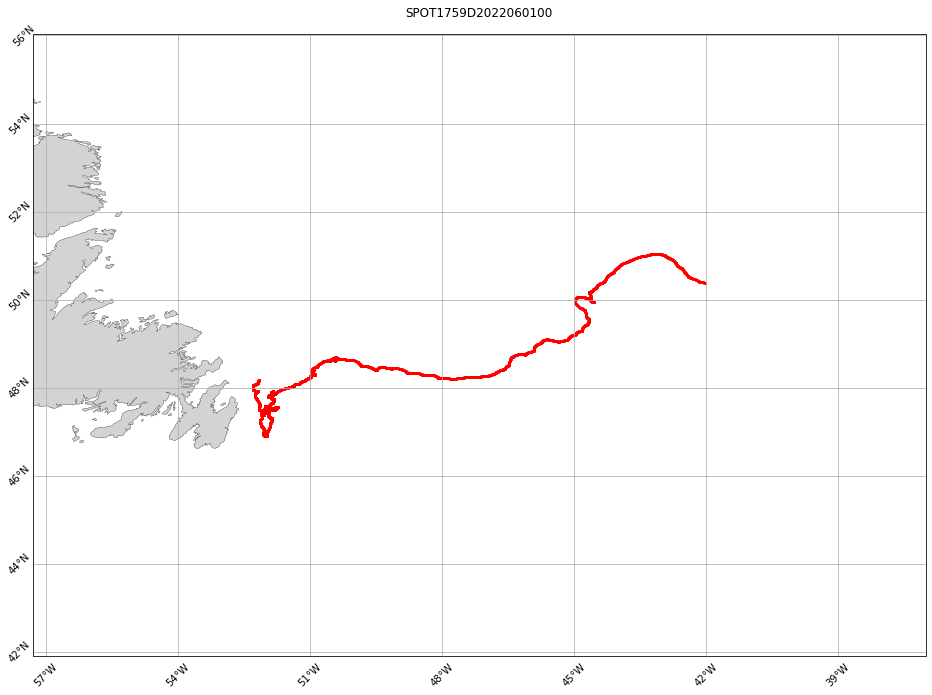



Processing file: SPOT1017.csv
Drifter track contains measurements with unrealistic speeds (14 points dropped).
Writing file: SPOT1017D2021120609.nc


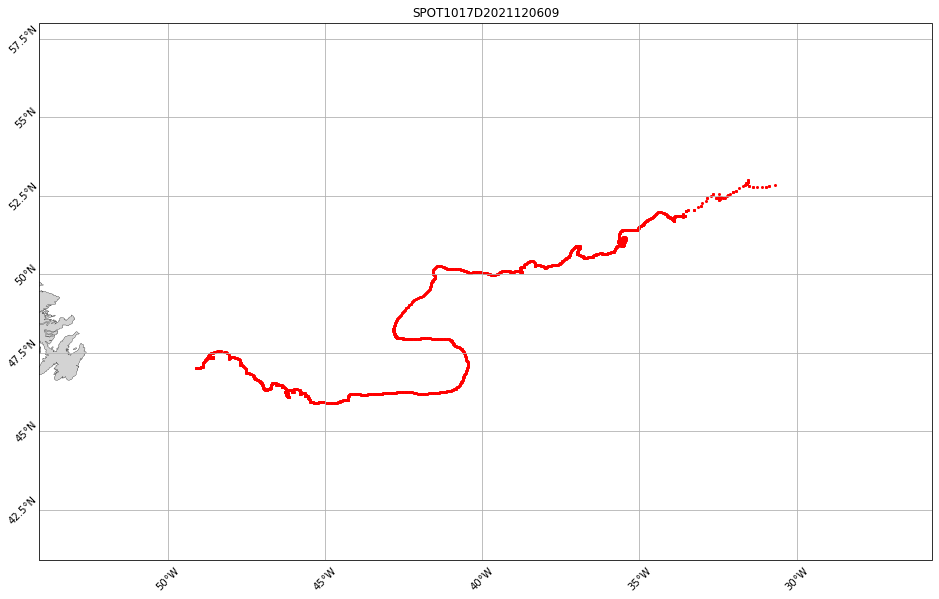

In [34]:
indir = "C:/Users/HoldenJe/Drift\projects/stokes_drift/input_data"
obsdir = os.path.join(indir, "obs_drifters")
outdir = os.path.join(indir, "obs_drifters", "netcdf")

files = [glob.glob(os.path.join(obsdir, drifter, "*.csv"))[0] for drifter in ["SPOT1759", "SPOT1017"]]

for file in files:
    
    print('\n\nProcessing file: ' + str(os.path.basename(file)))

    # read in the raw data
    df, attrdict, hdrdict = read_spotter_csv(file)
    
    # run some tests
    df = impossible_coordinate_test(df)    
    impossible_time_test(df, hdrdict)
    df = impossible_speed_test(df)
    
    # write out the netcdf files
    subdict = determine_track_length(df, hdrdict)
    for sub_drifter in subdict.keys():
        drifter = subdict[sub_drifter]
        df = drifter['df']
        hdr = drifter['hdr']
        write_drifttool_netcdf(df, hdr, attrdict, outdir)
        plot_drifter_segment(df, hdr)